In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import sqlite3
import os
import re
import plotly
import plotly.graph_objs as go
import cufflinks as cf
%matplotlib inline

In [2]:
cf.go_offline()

In [3]:
data_dir = './smart-money-concepts_old/updates/Data/'
os.listdir(data_dir)

['NQ_4H.csv',
 'NQ_1H.csv',
 'NQ_1D.csv',
 'NQ_1min.csv',
 'ES_5min.csv',
 'NQ_5min.csv',
 'EURUSD_15M.csv',
 'ES_1min.csv',
 'ES 12-24.Last.txt',
 'ES 12-24.Last_min.txt',
 'NQ_15min.csv',
 'NQ 12-24.Last.txt']

In [4]:
regex = r'\w*.csv'
csv_filenames = [i for i in os.listdir(data_dir) if re.match(regex, i)]
csv_filenames
#for i in os.listdir(data_dir):
#    if (i)

['NQ_4H.csv',
 'NQ_1H.csv',
 'NQ_1D.csv',
 'NQ_1min.csv',
 'ES_5min.csv',
 'NQ_5min.csv',
 'EURUSD_15M.csv',
 'ES_1min.csv',
 'NQ_15min.csv']

In [5]:
data_files = [pd.read_csv(data_dir + i) for i in csv_filenames]

In [6]:
data_files[0]

datetime      open      high       low     close  volume
0    2024-09-12 04:00:00  19538.25  19575.25  19504.25  19516.25    1925
1    2024-09-12 08:00:00  19514.50  19567.25  19494.50  19533.75    1534
2    2024-09-12 12:00:00  19535.25  19623.50  19418.25  19501.25    5326
3    2024-09-12 16:00:00  19497.50  19716.75  19497.50  19686.00    5602
4    2024-09-12 20:00:00  19685.75  19706.00  19636.50  19687.25    2248
..                   ...       ...       ...       ...       ...     ...
261  2024-11-07 20:00:00  21233.00  21253.00  21202.50  21227.25   84030
262  2024-11-08 00:00:00  21227.00  21245.00  21215.50  21226.75   11473
263  2024-11-08 04:00:00  21226.25  21263.25  21221.50  21240.00   12166
264  2024-11-08 08:00:00  21239.75  21250.50  21121.75  21162.00   34074
265  2024-11-08 12:00:00  21162.25  21232.25  21156.25  21192.25   58551

[266 rows x 6 columns]

<strong>NOTE:</strong> to avoid duplicates, use max timestamp as marker and then append the values after that.

<Axes: xlabel='datetime'>

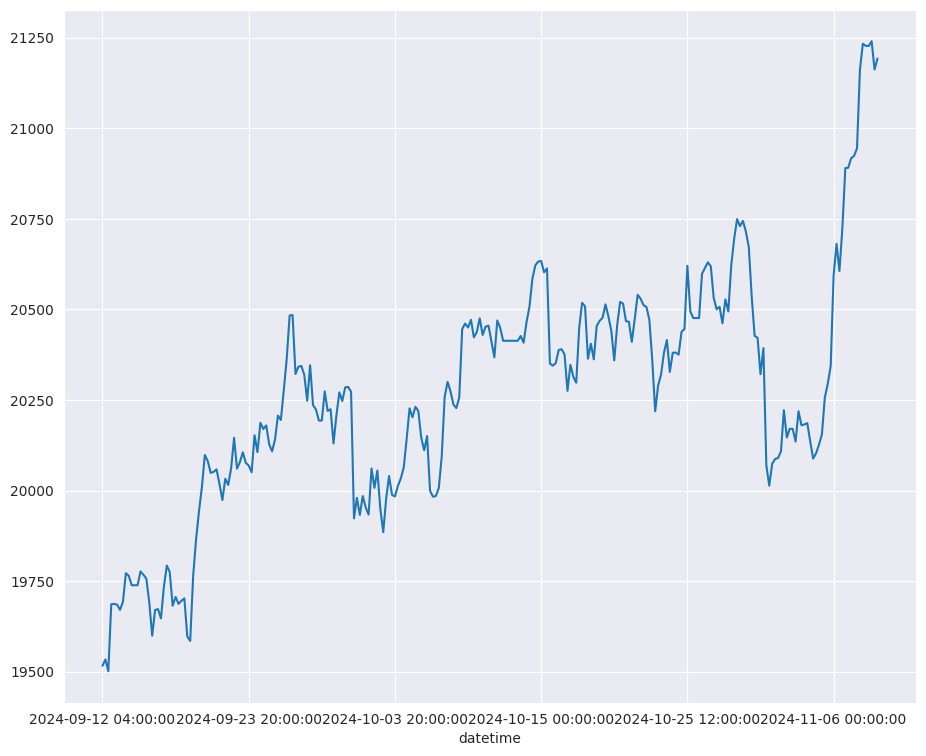

In [7]:
sns.set_style('darkgrid')
plt.figure(figsize=(11,9))
data_files[0].set_index('datetime').close.astype(float).plot()

In [8]:
#df = pd.read_csv('\\smart-money-concepts_old\\updates\\Data\\')

conn = sqlite3.connect('market_data.db')
cursor = conn.cursor()

In [9]:
cursor.execute('''
CREATE TABLE IF NOT EXISTS market_data (
    ticker TEXT,
    datetime TEXT,
    open REAL,
    high REAL,
    low REAL,
    close REAL,
    volume INTEGER
)
''')
conn.commit()

#cursor.execute('ALTER TABLE market_data RENAME COLUMN datetime TO timestamp;')
#conn.commit()

In [10]:
def fetch_data(ticker):
    """
    Function stub that fetches data
    TODO: add functionality to collect data using API and provided ticker value
    
    :ticker: ticker to fetch data for. eg: "IBM" 
    :return: market data for given ticker value
    """
    pass;

def fetch_data_local():
    """
    Placeholder function that fetches local data for now
    
    :return: dictionary with filename as key and dataframe as value
    """
    data_dir = './smart-money-concepts_old/updates/Data/'
    
    regex = r'\w*.csv'
    csv_filenames = [i for i in os.listdir(data_dir) if re.match(regex, i)]
    csv_filenames
    data_files = [pd.read_csv(data_dir + i) for i in csv_filenames]
    data = dict(zip(csv_filenames, data_files))
    for k,v in data:
        data[v]['ticker'] = k
    #for i in os.listdir(data_dir):
    #    if (i)
    return data


def fetch_data_local(ticker):
    """
    Placeholder function that fetches local data for now
    
    :ticker: index value for fetching local files. 
    :return: dictionary with filename as key and dataframe as value
    """
    data_dir = './smart-money-concepts_old/updates/Data/'
    data_files = pd.read_csv(data_dir + ticker)
    #data = dict([ticker], data_files)
    #for k,v in data:
    #    data[v]['ticker'] = k
    #for i in os.listdir(data_dir):
    #    if (i)
    data_files['ticker'] = ticker
    return data_files
    

In [12]:
## for getting lastest timestamp using sql
## NOTE: make sure timestamp values are typecasted properly in db!

def get_latest_timestamp(ticker):
    """
        gets the latest timestamp from the given data
        NOTE: If using local files, the 'ticker' value will be the filename
        :ticker: ticker to be used to access data point; for example it will be 'IBM' for IBM's ticker. This is entirely reliant on an external API to fetch the data
        :return: returns most recent (largest) timestamp value from table or None
    """
    query = """SELECT MAX(timestamp) FROM market_data WHERE ticker = ?"""
    cursor.execute(query, (ticker, ))
    result = cursor.fetchone()[0]
    return result

In [13]:
print (get_latest_timestamp("NQ_4H.csv"))

2024-11-08 12:00:00


In [14]:
## for storing data to db

def store_data_to_db(data, latest_timestamp = None):
    """
        stores the data (usually recently fetched) into our sql database
        
        :data:       the fetched data
        :latest:     the most recent timestamp from data
        :timestamp:  the most recent timestamp from data already stored in database
    """
    
    
    if data is not None:
        data = data.rename(columns={'datetime': 'timestamp'})
        if latest_timestamp:
            data = data[data['timestamp'] > latest_timestamp]
        
        if not data.empty:
            data.to_sql('market_data', conn, if_exists='append', index=False)
            print(f"Data for {data['ticker'].iloc[0]} stored successfully.")
        else:
            print(f"No New data to store.")
    else:
        print(f"No data to store.")

In [15]:
def main():
    tickers = ["NQ_4H.csv"] ## insert tickers you want market data for 
    for ticker in tickers:
        #latest_timestamp = get_latest_timestamp(ticker)
        data = fetch_data_local(ticker)
        #store_data_to_db(data, latest_timestamp)
        store_data_to_db(data)
    
    if __name__ == "__main__":
        main()

In [51]:
#main()

Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.


Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.


Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.


Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.


Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.


Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.


Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.


Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.
Data for NQ_4H.csv stored successfully.


KeyboardInterrupt: 

In [16]:
def query_data(ticker, start_time, end_time):
    """
    Custom query function to get ticker data for specified timeframe
    
    :ticker:      ticker value to get data for
    :start_time:  time value for start of filter
    :end_time:    time value for end of filter
    :return:      ticker data filtered by given time values 
    """
    
    query = f"""
    SELECT * FROM market_data
    WHERE ticker = '{ticker}'
    AND timestamp BETWEEN '{start_time}' AND '{end_time}'
    """
    df = pd.read_sql(query, conn)
    return df

In [17]:
df = query_data('NQ_4H.csv', '2024-09-12 12:00:00', '2024-11-07 20:00:00')

In [18]:
df

ticker            timestamp      open      high       low  \
0       NQ_4H.csv  2024-09-12 12:00:00  19535.25  19623.50  19418.25   
1       NQ_4H.csv  2024-09-12 16:00:00  19497.50  19716.75  19497.50   
2       NQ_4H.csv  2024-09-12 20:00:00  19685.75  19706.00  19636.50   
3       NQ_4H.csv  2024-09-13 00:00:00  19687.75  19706.75  19654.50   
4       NQ_4H.csv  2024-09-13 04:00:00  19685.75  19722.00  19665.00   
...           ...                  ...       ...       ...       ...   
409235  NQ_4H.csv  2024-11-07 04:00:00  20917.25  20966.25  20907.75   
409236  NQ_4H.csv  2024-11-07 08:00:00  20923.25  20961.00  20915.00   
409237  NQ_4H.csv  2024-11-07 12:00:00  20943.25  21167.25  20941.00   
409238  NQ_4H.csv  2024-11-07 16:00:00  21160.75  21233.00  21124.25   
409239  NQ_4H.csv  2024-11-07 20:00:00  21233.00  21253.00  21202.50   

           close  volume  
0       19501.25    5326  
1       19686.00    5602  
2       19687.25    2248  
3       19685.00    3342  
4       19670.50    4307  
...          ...     ...  
409235  20923.50   15300  
409236  20944.25   20273  
409237  21161.00  162566  
409238  21233.00  155805  
409239  21227.25   84030  

[409240 rows x 7 columns]

In [19]:
fetch_data_local("NQ_4H.csv")

datetime      open      high       low     close  volume  \
0    2024-09-12 04:00:00  19538.25  19575.25  19504.25  19516.25    1925   
1    2024-09-12 08:00:00  19514.50  19567.25  19494.50  19533.75    1534   
2    2024-09-12 12:00:00  19535.25  19623.50  19418.25  19501.25    5326   
3    2024-09-12 16:00:00  19497.50  19716.75  19497.50  19686.00    5602   
4    2024-09-12 20:00:00  19685.75  19706.00  19636.50  19687.25    2248   
..                   ...       ...       ...       ...       ...     ...   
261  2024-11-07 20:00:00  21233.00  21253.00  21202.50  21227.25   84030   
262  2024-11-08 00:00:00  21227.00  21245.00  21215.50  21226.75   11473   
263  2024-11-08 04:00:00  21226.25  21263.25  21221.50  21240.00   12166   
264  2024-11-08 08:00:00  21239.75  21250.50  21121.75  21162.00   34074   
265  2024-11-08 12:00:00  21162.25  21232.25  21156.25  21192.25   58551   

        ticker  
0    NQ_4H.csv  
1    NQ_4H.csv  
2    NQ_4H.csv  
3    NQ_4H.csv  
4    NQ_4H.csv  
..         ...  
261  NQ_4H.csv  
262  NQ_4H.csv  
263  NQ_4H.csv  
264  NQ_4H.csv  
265  NQ_4H.csv  

[266 rows x 7 columns]

In [20]:
data_files = {csv_filenames, [pd.read_csv(data_dir + i) for i in csv_filenames]}
data_files

TypeError: unhashable type: 'list'

In [21]:
data.columns

NameError: name 'data' is not defined

In [22]:
print(list(data_files))

[                datetime      open      high       low     close  volume
0    2024-09-12 04:00:00  19538.25  19575.25  19504.25  19516.25    1925
1    2024-09-12 08:00:00  19514.50  19567.25  19494.50  19533.75    1534
2    2024-09-12 12:00:00  19535.25  19623.50  19418.25  19501.25    5326
3    2024-09-12 16:00:00  19497.50  19716.75  19497.50  19686.00    5602
4    2024-09-12 20:00:00  19685.75  19706.00  19636.50  19687.25    2248
..                   ...       ...       ...       ...       ...     ...
261  2024-11-07 20:00:00  21233.00  21253.00  21202.50  21227.25   84030
262  2024-11-08 00:00:00  21227.00  21245.00  21215.50  21226.75   11473
263  2024-11-08 04:00:00  21226.25  21263.25  21221.50  21240.00   12166
264  2024-11-08 08:00:00  21239.75  21250.50  21121.75  21162.00   34074
265  2024-11-08 12:00:00  21162.25  21232.25  21156.25  21192.25   58551

[266 rows x 6 columns],                 datetime      open      high       low     close  volume
0    2024-09-12 04:00:00 

In [23]:
dict(zip(csv_filenames, data_files))

{'NQ_4H.csv':                 datetime      open      high       low     close  volume
 0    2024-09-12 04:00:00  19538.25  19575.25  19504.25  19516.25    1925
 1    2024-09-12 08:00:00  19514.50  19567.25  19494.50  19533.75    1534
 2    2024-09-12 12:00:00  19535.25  19623.50  19418.25  19501.25    5326
 3    2024-09-12 16:00:00  19497.50  19716.75  19497.50  19686.00    5602
 4    2024-09-12 20:00:00  19685.75  19706.00  19636.50  19687.25    2248
 ..                   ...       ...       ...       ...       ...     ...
 261  2024-11-07 20:00:00  21233.00  21253.00  21202.50  21227.25   84030
 262  2024-11-08 00:00:00  21227.00  21245.00  21215.50  21226.75   11473
 263  2024-11-08 04:00:00  21226.25  21263.25  21221.50  21240.00   12166
 264  2024-11-08 08:00:00  21239.75  21250.50  21121.75  21162.00   34074
 265  2024-11-08 12:00:00  21162.25  21232.25  21156.25  21192.25   58551
 
 [266 rows x 6 columns],
 'NQ_1H.csv':                 datetime      open      high       low    

In [24]:
data = data_files[0].set_index('datetime')[['close']]
fig = go.Figure(data=[go.Scatter(x=data.index, y=data['close'])])

In [25]:
data = data_files[0]
fig = go.Figure(data = [go.Candlestick(x = data['datetime'],
                                       open= data['open'],
                                       close = data['close'],
                                       high = data['high'],
                                       low = data['low']
                                        )])

In [26]:
fig

In [27]:
import sys
import os
import time

In [28]:
abs_path = os.path.abspath('./smart-money-concepts_old/Extend')

In [29]:
sys.path.insert(0, abs_path)

In [30]:
from SHSL import detect_swing_highs_lows

In [31]:
data.columns = [str.capitalize(column) for column in data.columns]

In [32]:
start = time.time()
delta_data = detect_swing_highs_lows(data)
end = time.time()
print(f"Function executed in {end - start} seconds")

Function executed in 0.029830455780029297 seconds


In [34]:
delta_data

Datetime      Open      High       Low     Close  Volume  SH  \
0    2024-09-12 04:00:00  19538.25  19575.25  19504.25  19516.25    1925       
1    2024-09-12 08:00:00  19514.50  19567.25  19494.50  19533.75    1534       
2    2024-09-12 12:00:00  19535.25  19623.50  19418.25  19501.25    5326       
3    2024-09-12 16:00:00  19497.50  19716.75  19497.50  19686.00    5602       
4    2024-09-12 20:00:00  19685.75  19706.00  19636.50  19687.25    2248       
..                   ...       ...       ...       ...       ...     ...  ..   
261  2024-11-07 20:00:00  21233.00  21253.00  21202.50  21227.25   84030       
262  2024-11-08 00:00:00  21227.00  21245.00  21215.50  21226.75   11473       
263  2024-11-08 04:00:00  21226.25  21263.25  21221.50  21240.00   12166  SH   
264  2024-11-08 08:00:00  21239.75  21250.50  21121.75  21162.00   34074       
265  2024-11-08 12:00:00  21162.25  21232.25  21156.25  21192.25   58551       

    SL USH USL  
0               
1               
2               
3               
4               
..  ..  ..  ..  
261             
262             
263             
264             
265             

[266 rows x 10 columns]

In [54]:
#data = data_files[0]
fig = go.Figure(data = [go.Candlestick(x = delta_data['Datetime'],
                                       open= delta_data['Open'],
                                       close = delta_data['Close'],
                                       high = delta_data['High'],
                                       low = delta_data['Low']
                                        )])
fig

In [77]:
annotations = []
annotations.append(go.Annotation(
                x=index,
                y=row['SH'],
                text=f'SH: {row["SH"]}',
                showarrow=False,
                xref='x',
                yref='y'
            ))
annotations.append(go.Annotation(
                x=index,
                y=row['SL'],
                text=f'SL: {row["SL"]}',
                showarrow=False,
                xref='x',
                yref='y'
            ))


In [37]:
annotations = []
for index, row in delta_data.iterrows():
        if not pd.isna(row['SH']):
            annotations.append(dict(
                x=index,
                y=row['SH'],
                text=f'SH: {row["SH"]}',
                showarrow=False,
                xref='x',
                yref='y'
            ))
        
        if not pd.isna(row['SL']):
            annotations.append(dict(
                x=index,
                y=row['SL'],
                text=f'SL: {row["SL"]}',
                showarrow=False,
                xref='x',
                yref='y'
            ))
        
        if not pd.isna(row['USH']):
            annotations.append(dict(
                x=index,
                y=row['USH'],
                text=f'USH: {row["USH"]}',
                showarrow=False,
                xref='x',
                yref='y'
            ))
        
        if not pd.isna(row['USL']):
            annotations.append(dict(
                x=index,
                y=row['USL'],
                text=f'USL: {row["USL"]}',
                showarrow=False,
                xref='x',
                yref='y'
            ))

fig.update_layout(annotations=annotations, 
                  xaxis=dict(
                            range=[delta_data['Datetime'].min(), delta_data['Datetime'].max()], 
                            rangeslider=dict(
                                visible=True,  # Make the rangeslider visible
                                range=[delta_data['Datetime'].min(), delta_data['Datetime'].max()]
                                )
                            ),                  
                 )
#fig.update_annotations(annotations)

In [118]:
annotations = []
for index, row in detla_data.iterrows():
        if row['SH'] == 'SH':
            annotations.append(dict(
                x=index,
                y=row['High'],
                text=f'SH: {row["SH"]}',
                showarrow=True,
                xref='x',
                yref='y'
            ))
    
        if row['SL'] == 'SL':
            annotations.append(dict(
                x=index,
                y=row['Low'],
                text=f'SL: {row["SL"]}',
                showarrow=True,
                xref='x',
                yref='y'
            ))
        if row['USH'] == 'USH':
            annotations.append(dict(
                x=index,
                y=row['High'],
                text=f'USH: {row["USH"]}',
                showarrow=True,
                xref='x',
                yref='y'
            ))

        if row['USL'] == 'USL':
            annotations.append(dict(
                x=index,
                y=row['Low'],
                text=f'USL: {row["USL"]}',
                showarrow=True,
                xref='x',
                yref='y'
            ))

for annotation in annotations:
    fig.add_trace(go.Scatter(
        x=[annotation['x']],
        y=[annotation['y']],
        mode='markers',
        marker=dict(color='blue', symbol='square'),
        showlegend=False,  # Hide this trace from the legend
        hoverinfo='none'   # Don't display any information on hover
    ))
            
fig.update_layout(annotations=annotations, 
                  xaxis=dict(
                            range=[detla_data['Datetime'].min(), detla_data['Datetime'].max()], 
                            rangeslider=dict(
                                visible=True,  # Make the rangeslider visible
                                range=[detla_data['Datetime'].min(), detla_data['Datetime'].max()]
                                )
                            ),                  
                 )


In [38]:
for i in annotations:
    if i['showarrow'] == True:
        print (f'{i}')

In [39]:
annotations

[{'x': 0,
  'y': '',
  'text': 'SH: ',
  'showarrow': False,
  'xref': 'x',
  'yref': 'y'},
 {'x': 0,
  'y': '',
  'text': 'SL: ',
  'showarrow': False,
  'xref': 'x',
  'yref': 'y'},
 {'x': 0,
  'y': '',
  'text': 'USH: ',
  'showarrow': False,
  'xref': 'x',
  'yref': 'y'},
 {'x': 0,
  'y': '',
  'text': 'USL: ',
  'showarrow': False,
  'xref': 'x',
  'yref': 'y'},
 {'x': 1,
  'y': '',
  'text': 'SH: ',
  'showarrow': False,
  'xref': 'x',
  'yref': 'y'},
 {'x': 1,
  'y': '',
  'text': 'SL: ',
  'showarrow': False,
  'xref': 'x',
  'yref': 'y'},
 {'x': 1,
  'y': '',
  'text': 'USH: ',
  'showarrow': False,
  'xref': 'x',
  'yref': 'y'},
 {'x': 1,
  'y': '',
  'text': 'USL: ',
  'showarrow': False,
  'xref': 'x',
  'yref': 'y'},
 {'x': 2,
  'y': '',
  'text': 'SH: ',
  'showarrow': False,
  'xref': 'x',
  'yref': 'y'},
 {'x': 2,
  'y': '',
  'text': 'SL: ',
  'showarrow': False,
  'xref': 'x',
  'yref': 'y'},
 {'x': 2,
  'y': '',
  'text': 'USH: ',
  'showarrow': False,
  'xref': 'x',

In [42]:
delta_data[delta_data['USH'] != '']

Datetime      Open      High       Low     Close  Volume SH  \
54   2024-09-24 12:00:00  20106.00  20214.75  19953.00  20187.00  223720      
118  2024-10-08 16:00:00  20257.25  20329.50  20164.75  20300.00  150207      
124  2024-10-09 16:00:00  20446.00  20482.75  20355.00  20460.75  161304      
176  2024-10-21 12:00:00  20359.25  20554.50  20345.00  20456.25  235876      
194  2024-10-24 12:00:00  20415.25  20428.50  20264.00  20327.50  217073      
200  2024-10-25 12:00:00  20445.00  20707.25  20443.00  20620.25  268355      
233  2024-11-01 12:00:00  20109.50  20288.00  20057.50  20221.75  260825      

    SL  USH  USL  
54      USH  USL  
118     USH       
124     USH       
176     USH       
194     USH       
200     USH       
233     USH

In [43]:
delta_data.columns

Index(['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume', 'SH', 'SL', 'USH',
       'USL'],
      dtype='object')

In [123]:
annotations = []
markers = []

columns = {
    'SH': ('SH', 'High'),
    'SL': ('SL', 'Low'),
    'USH': ('USH', 'High'),
    'USL': ('USL', 'Low')
}

for index, row in delta_data.iterrows():
    for col, (text, y_ref) in columns.items():
        if row[col] == text:
            annotations.append(dict(
                x=index,
                y=row[y_ref],
                text=text,
                showarrow=False,
                xref='x',
                yref='y'
            ))
            
            markers.append(dict(
                type='line',
                x0=index,
                y0=min(row['Low'], row[y_ref]),
                x1=index,
                y1=max(row['High'], row[y_ref]),
                color='red' if col in ['SL', 'USL'] else 'blue' if col == 'USH' else 'green',
                opacity=0.5
            ))

In [126]:
annotations = []
markers = []

columns = {
    'SH': ('SH', 'High'),
    'SL': ('SL', 'Low'),
    'USH': ('USH', 'High'),
    'USL': ('USL', 'Low')
}

for index, row in delta_data.iterrows():
    for col, (text, y_ref) in columns.items():
        annotations.append(dict(
            x=index,
            y=row[y_ref],
            text=text,
            showarrow=False,
            xref='x',
            yref='y'
        ))
        
        markers.append(dict(
            type='line',
            x0=index,
            y0=min(row['Low'], row[y_ref]),
            x1=index,
            y1=max(row['High'], row[y_ref]),
            color='red' if col in ['SL', 'USL'] else 'blue' if col == 'USH' else 'green',
            opacity=0.5
        ))

In [127]:
annotations

[{'x': 0,
  'y': 19575.25,
  'text': 'SH',
  'showarrow': False,
  'xref': 'x',
  'yref': 'y'},
 {'x': 0,
  'y': 19504.25,
  'text': 'SL',
  'showarrow': False,
  'xref': 'x',
  'yref': 'y'},
 {'x': 0,
  'y': 19575.25,
  'text': 'USH',
  'showarrow': False,
  'xref': 'x',
  'yref': 'y'},
 {'x': 0,
  'y': 19504.25,
  'text': 'USL',
  'showarrow': False,
  'xref': 'x',
  'yref': 'y'},
 {'x': 1,
  'y': 19567.25,
  'text': 'SH',
  'showarrow': False,
  'xref': 'x',
  'yref': 'y'},
 {'x': 1,
  'y': 19494.5,
  'text': 'SL',
  'showarrow': False,
  'xref': 'x',
  'yref': 'y'},
 {'x': 1,
  'y': 19567.25,
  'text': 'USH',
  'showarrow': False,
  'xref': 'x',
  'yref': 'y'},
 {'x': 1,
  'y': 19494.5,
  'text': 'USL',
  'showarrow': False,
  'xref': 'x',
  'yref': 'y'},
 {'x': 2,
  'y': 19623.5,
  'text': 'SH',
  'showarrow': False,
  'xref': 'x',
  'yref': 'y'},
 {'x': 2,
  'y': 19418.25,
  'text': 'SL',
  'showarrow': False,
  'xref': 'x',
  'yref': 'y'},
 {'x': 2,
  'y': 19623.5,
  'text': 'US

In [125]:
fig.update_layout(annotations=annotations, 
                  xaxis=dict(
                            range=[detla_data['Datetime'].min(), detla_data['Datetime'].max()], 
                            rangeslider=dict(
                                visible=True,  # Make the rangeslider visible
                                range=[detla_data['Datetime'].min(), detla_data['Datetime'].max()]
                                )
                            ),                  
                 )


In [128]:
fig.update_layout(
    xaxis=dict(
        range=[detla_data['Datetime'].min(), detla_data['Datetime'].max()], 
        rangeslider=dict(
            visible=True,  # Make the rangeslider visible
            range=[detla_data['Datetime'].min(), detla_data['Datetime'].max()]
        )
    ),
    annotations=annotations,
    xaxis_title='Date',
    yaxis_title='Price'
)

In [51]:
fig = go.Figure(data=[go.Candlestick(
    x=delta_data['Datetime'],
    open=delta_data['Open'],
    high=delta_data['High'],
    low=delta_data['Low'],
    close=delta_data['Close']
)])

annotations = []
for index, row in delta_data.iterrows():
    for col in ['SH', 'SL', 'USH', 'USL']:
        if not pd.isnull(row[col]) and row[col] != '':
            x = index
            y = row['High'] if row[col] == 'USH' else row['Low']
            text = row[col]
            showarrow = True
            annotations.append(dict(
                x=x,
                y=y,
                ax=x,
                ay=y,
                xref='x',
                yref='y',
                showarrow=showarrow,
                text=text
            ))

fig.update_layout(
    xaxis=dict(
        type='date'
    ),
    annotations=annotations
)

In [52]:
annotations

[{'x': 9,
  'y': 19714.0,
  'ax': 9,
  'ay': 19714.0,
  'xref': 'x',
  'yref': 'y',
  'showarrow': True,
  'text': 'SH'},
 {'x': 17,
  'y': 19529.0,
  'ax': 17,
  'ay': 19529.0,
  'xref': 'x',
  'yref': 'y',
  'showarrow': True,
  'text': 'SL'},
 {'x': 23,
  'y': 19709.0,
  'ax': 23,
  'ay': 19709.0,
  'xref': 'x',
  'yref': 'y',
  'showarrow': True,
  'text': 'SH'},
 {'x': 30,
  'y': 19558.0,
  'ax': 30,
  'ay': 19558.0,
  'xref': 'x',
  'yref': 'y',
  'showarrow': True,
  'text': 'SL'},
 {'x': 36,
  'y': 20064.0,
  'ax': 36,
  'ay': 20064.0,
  'xref': 'x',
  'yref': 'y',
  'showarrow': True,
  'text': 'SH'},
 {'x': 41,
  'y': 19860.0,
  'ax': 41,
  'ay': 19860.0,
  'xref': 'x',
  'yref': 'y',
  'showarrow': True,
  'text': 'SL'},
 {'x': 45,
  'y': 20055.25,
  'ax': 45,
  'ay': 20055.25,
  'xref': 'x',
  'yref': 'y',
  'showarrow': True,
  'text': 'SH'},
 {'x': 54,
  'y': 20214.75,
  'ax': 54,
  'ay': 20214.75,
  'xref': 'x',
  'yref': 'y',
  'showarrow': True,
  'text': 'USH'},
 {'x'

In [55]:
fig = go.Figure(data = [go.Candlestick(x = delta_data['Datetime'],
                                       open= delta_data['Open'],
                                       close = delta_data['Close'],
                                       high = delta_data['High'],
                                       low = delta_data['Low']
                                        )])
fig.add_scatter(
    x=delta_data['Datetime'],
    y=1,
    mode='markers',
    text=delta_data['SH'].fillna('No Data'),
    hoverinfo='text'
)

fig.add_scatter(
    x=delta_data['Datetime'],
    y=0.9,
    mode='markers',
    text=delta_data['SL'].fillna('No Data'),
    hoverinfo='text'
)

fig.add_scatter(
    x=delta_data['Datetime'],
    y=1.1,
    mode='markers',
    text=delta_data['USH'].fillna('No Data'),
    hoverinfo='text'
)

fig.add_scatter(
    x=delta_data['Datetime'],
    y=0.8,
    mode='markers',
    text=delta_data['USL'].fillna('No Data'),
    hoverinfo='text'
)

ValueError: 
    Invalid value of type 'builtins.int' received for the 'y' property of scatter
        Received value: 1

    The 'y' property is an array that may be specified as a tuple,
    list, numpy array, or pandas Series

In [57]:
fig = go.Figure(data = [go.Candlestick(x = delta_data['Datetime'],
                                       open= delta_data['Open'],
                                       close = delta_data['Close'],
                                       high = delta_data['High'],
                                       low = delta_data['Low']
                                        )])

fig.add_scatter(
    x=delta_data['Datetime'],
    y=[max(y) + 0.01 for y in zip(delta_data['High'], delta_data['Low'])],
    mode='markers',
    text=['SH' if y == max(z) else 'SL' if y == min(z) else '' for z in zip(delta_data['High'], delta_data['Low'])],
    hoverinfo='text'
)

fig.add_scatter(
    x=delta_data['Datetime'],
    y=[min(y) - 0.01 for y in zip(delta_data['High'], delta_data['Low'])],
    mode='markers',
    text=['USH' if y == min(z) else 'USL' if y == max(z) else '' for z in zip(delta_data['High'], delta_data['Low'])],
    hoverinfo='text'
)